In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime
import seaborn as sns

Chargement des données

-recolte.csv : données de rendement agricole

-climat.csv : données climatiques

-persticide.csv : données sur l’utilisation de pesticides

In [ ]:
df_crop= pd.read_csv('./data/exercice_2/recolte.csv')
df_temp= pd.read_csv('./data/exercice_2/climat.csv')
df_dis= pd.read_csv('./data/exercice_2/persticide.csv')

Préparation et transformation des données

Les colonnes des mois sont supprimées dans les données climatiques pour ne garder que les valeurs annuelles.

In [145]:
mois = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
df_temp = df_temp.drop(columns=mois)

Les données climatiques sont pivotées pour avoir une colonne par paramètre climatique et une ligne par année.

In [ ]:
df_temp = df_temp.pivot(index='YEAR', columns='PARAMETER', values='ANN').reset_index()
#df_temp.info()

Les trois jeux de données sont renommés pour avoir des colonnes claires (Year, Rendement, persticide)

In [ ]:
df_crop = df_crop[['Year', 'Value']].rename(columns={'Value': 'Rendement'})
df_dis = df_dis[['Year', 'Value']].rename(columns={'Value': 'persticide'})
df_temp=df_temp.rename(columns={'YEAR': 'Year'})

fusion de l'ensemble des données sur la colonne Year pour obtenir un seul tableau qui contient toutes les informations par année

In [148]:
df = pd.merge(df_crop, df_temp, on='Year', how='inner')
df = pd.merge(df, df_dis, on='Year', how='inner')

Analyse de la corrélation des variables avec le rendement


<ipython-input-149-074fe1e949ec>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')


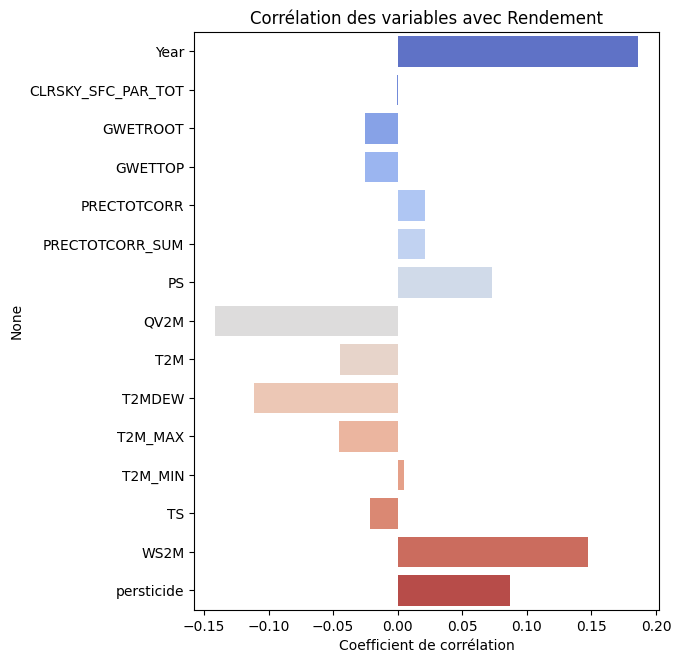

In [ ]:

corr_target = df.corr()['Rendement'].drop('Rendement')
plt.figure(figsize=(6, len(corr_target)*0.5))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')
plt.title('Corrélation des variables avec Rendement')
plt.xlabel('Coefficient de corrélation')
plt.show()

Analyse de la corrélation des variables

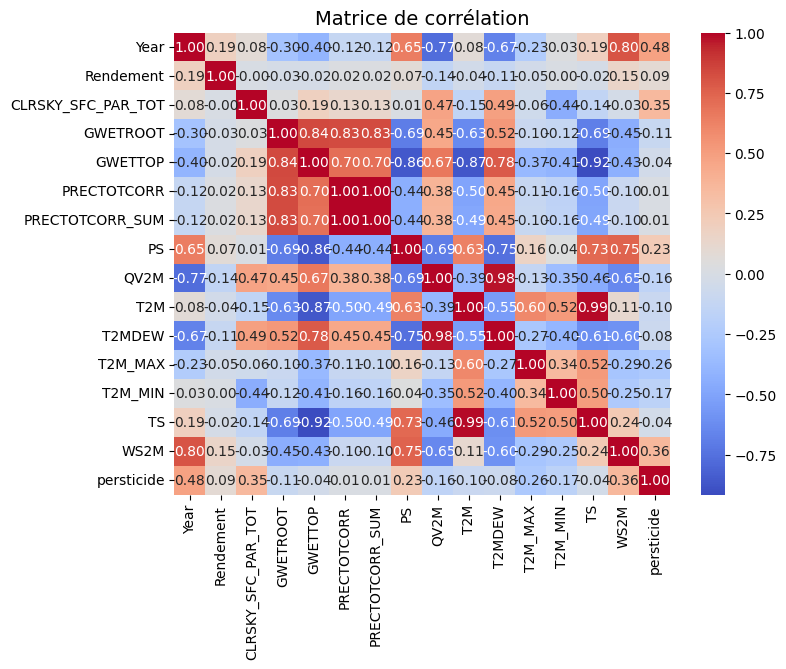

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation", fontsize=14)
plt.show()

Séparation des variables explicatives (X) et de la variable cible (y)

In [ ]:
X = df.drop(columns=['Rendement']).values
y = df['Rendement'].values.reshape(-1, 1)

Standardisation des variables explicatives et de la cible

In [ ]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

Création des séquences temporelles pour le modèle

La fonction create_sequences sert à transformer des données tabulaires classiques en séquences temporelles adaptées aux réseaux de neurones récurrents (comme LSTM ou GRU), qui sont spécialisés dans le traitement des séries temporelles

In [154]:
def create_sequences(X, y, n_steps=3):
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X[i:i+n_steps])
        y_seq.append(y[i+n_steps])
    return np.array(X_seq), np.array(y_seq)

n_steps = 3
X_seq, y_seq = create_sequences(X_scaled, y_scaled, n_steps)


Séparation des données en ensembles d'entraînement et de test

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

print(X_train.shape, X_test.shape)


(60, 3, 15) (15, 3, 15)


Construction et entraînement du modèle LSTM

In [159]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, X_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - loss: 0.2580 - mae: 0.4348 - val_loss: 4.4578 - val_mae: 2.0307
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.2421 - mae: 0.4064 - val_loss: 4.6855 - val_mae: 2.0869
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2022 - mae: 0.3547 - val_loss: 4.9219 - val_mae: 2.1429
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1835 - mae: 0.3340 - val_loss: 5.1529 - val_mae: 2.1961
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1933 - mae: 0.3325 - val_loss: 5.3753 - val_mae: 2.2456
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.2017 - mae: 0.3330 - val_loss: 5.5584 - val_mae: 2.2851
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2004 - mae: 0.3311 - val_loss: 5.7067 - val_mae: 2.3166
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1739 - mae: 0.3081 - val_loss: 5.7953 - val_mae: 2.3348
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.1541 - mae: 0.2938 - v

Prédiction et visualisation des résultats

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
[[-0.52681655]
 [-0.46386763]
 [-0.41459295]
 [-0.47099668]
 [-0.5497152 ]
 [-0.49628985]
 [-0.5138159 ]
 [-0.47731692]
 [-0.5042024 ]
 [-0.51424235]
 [-0.53598815]
 [-0.43813443]
 [-0.45089066]
 [-0.44299215]
 [-0.43851307]]


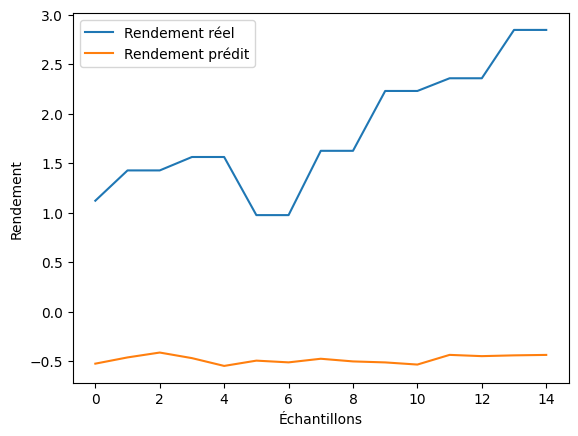

In [160]:
y_pred = model.predict(X_test)
print(y_pred)

plt.plot(y_test, label='Rendement réel')
plt.plot(y_pred, label='Rendement prédit')
plt.xlabel('Échantillons')
plt.ylabel('Rendement')
plt.legend()
plt.show()


Évaluation des performances du modèle

In [161]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE :", mae)
print("RMSE :", rmse)
print("R2 :", r2)

MAE : 2.2920535060056273
RMSE : 2.366289913360786
R2 : -14.404707214928822
